In [ ]:
!nvidia-smi


Tue Oct 29 15:41:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:42:00.0 Off |                  Off |
| 30%   38C    P8             28W /  450W |       1MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
base_model_id = "microsoft/Phi-3.5-mini-instruct"
data_id = "AlanYky/tweets-topic-instruct-filtered"

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)

model.to("cuda")

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3FlashAttention2(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=307

In [ ]:
from datasets import load_dataset, concatenate_datasets
import torch
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import os
import matplotlib.pyplot as plt
import wandb
import transformers
from datetime import datetime
import logging
from tqdm import tqdm
from collections import Counter

In [ ]:
def generate_tweet(instruction, pipe, generation_args):
    # Prepare the messages structure
    messages = [
        # {
        #     "role": "system",
        #     "content": "You are a creative assistant skilled at writing human-like tweets. Respond only with the tweet text."
        # },
        {
            "role": "user",
            "content": instruction
        }
    ]

    # Generate the tweet response
    output = pipe(messages, **generation_args)

    # Extract and return the generated tweet text
    return output[0]['generated_text']


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_train_dataset ]
    lengths += [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_val_dataset]
    print(len(lengths))
    print("Max length: ", max(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

def formatting_func(example):
    instruction = example['instruction']
    tweet = example['text']
    return f"<|endoftext|><|user|>\n{instruction} <|end|>\n<|assistant|>\n{tweet}"

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))



In [ ]:
train_dataset = load_dataset(data_id)

README.md:   0%|          | 0.00/395 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.88M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13453 [00:00<?, ? examples/s]

In [ ]:
train_dataset['train']

Dataset({
    features: ['instruction', 'text', 'target', '__index_level_0__'],
    num_rows: 13453
})

In [ ]:
# Shuffle the combined dataset
shuffled_dataset = train_dataset['train'].shuffle(seed=42)
shuffled_dataset

Dataset({
    features: ['instruction', 'text', 'target', '__index_level_0__'],
    num_rows: 13453
})

In [ ]:
# Split into training and validation datasets
validation_dataset = shuffled_dataset.select(range(5))  # First 10 samples for validation
training_dataset = shuffled_dataset.select(range(5, len(shuffled_dataset)))  # Rest for training

# Print the 10 samples in the validation dataset
for i, sample in enumerate(validation_dataset):
    print(f"Sample {i+1}:", sample)
    print("\n")

Sample 1: {'instruction': 'Generate a tweet about Simba.', 'text': 'Zazu, lived long miserable years watching the kingdom literally reduced to dirt by Scar and no doubt prayed for a miracle, sees Simba, who is alive and well, and the rightful king who was presumed dead along with his father at the gorge return home: "hey welcome back"', 'target': 'Simba', '__index_level_0__': 6464}


Sample 2: {'instruction': 'Generate a tweet about Gayl Jones.', 'text': "Not us discussing this book and Gayl Jones' wild bio on a group chat 😅", 'target': 'Gayl Jones', '__index_level_0__': 10993}


Sample 3: {'instruction': 'Generate a tweet about Roger Clark.', 'text': 'Roger Clark posting threads about taking care of your mental health along with the "you\'re alright gurl" cameo vid on a night when I\'ve had a HUGE anxiety attack has given me the serotonin needed to make it through the week tbh🤙', 'target': 'Roger Clark', '__index_level_0__': 2849}


Sample 4: {'instruction': 'Generate a tweet about Ba

In [ ]:
tokenized_train_dataset = training_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),
)

tokenized_val_dataset = validation_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),
)

Map (num_proc=64):   0%|          | 0/13448 [00:00<?, ? examples/s]

num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Map (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(tokenized_train_dataset[1]["input_ids"])

'<|endoftext|><|user|> Generate a tweet about FILHAAL2. <|end|><|assistant|> Filhall is the 3rd fastest song to reach 1B (527 days ) FILHAAL2 SONG DAY'

13453
Max length:  310


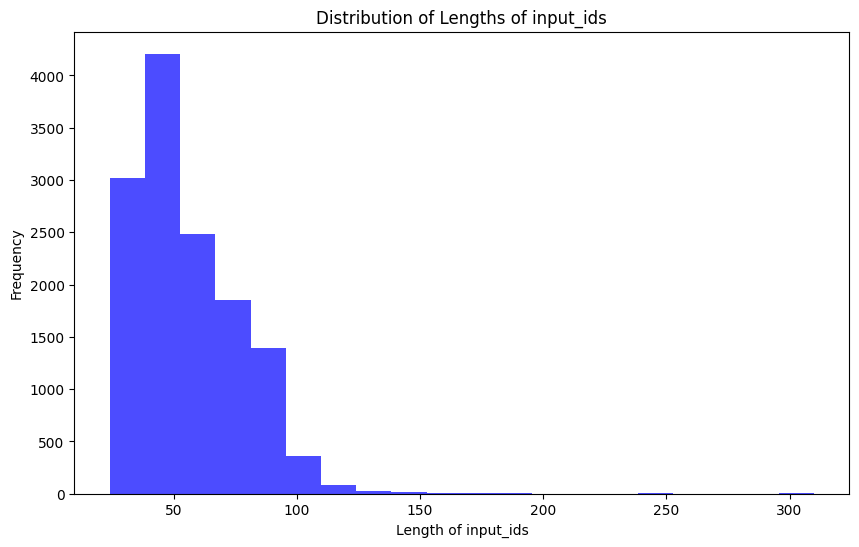

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt_padding(prompt):
    result = tokenizer(
        formatting_func(prompt),
        max_length=150,
        truncation=True,
        padding='max_length',
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = training_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)

tokenized_val_dataset = validation_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)

Map (num_proc=64):   0%|          | 0/13448 [00:00<?, ? examples/s]

num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Map (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(
    training_dataset.column_names
)

tokenized_val_dataset = tokenized_val_dataset.remove_columns(
    validation_dataset.column_names
)


13453
Max length:  150


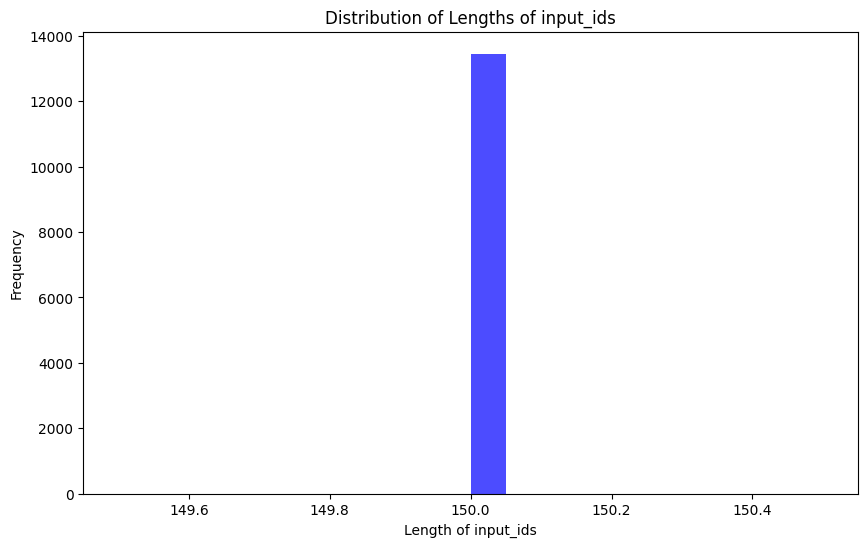

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
len(tokenized_train_dataset[1]["input_ids"])

150

In [ ]:
tokenizer.decode(tokenized_train_dataset[40]["input_ids"])

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

In [ ]:
# bd989240e730a8a990308fd969e1a2478fad8371
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
logging.getLogger("transformers").setLevel(logging.DEBUG)
os.environ["WANDB_PROJECT"]="phi35-tweet-v2"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
run_name = "phi3_2"
output_dir = "./" + run_name

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset.select(range(1)),
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        num_train_epochs=1,
        output_dir=output_dir,
        warmup_steps=50,
        gradient_accumulation_steps=1,
        learning_rate=1e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",               # Disable checkpoint saving
        save_steps=5000,
        save_total_limit = 1,                     # Mixed precision for efficiency
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
You have loaded a model on multiple GPUs. `is_model_parallel` attribute will be force-set to `True` to avoid any unexpected behavior such as device placement mismatching.
Currently training with a batch size of: 1
***** Running training *****
  Num examples = 13,448
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 13,448
  Number of trainable parameters = 3,821,079,552
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
100,1.850500,3.415247


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Step,Training Loss,Validation Loss
100,1.850500,3.415247
200,1.922700,3.396976
300,1.907700,3.408106
400,1.875900,3.452911
500,1.946400,3.424039
600,2.071200,3.478635
700,1.899000,3.504724
800,1.721600,3.458200
900,1.772900,3.455408
1000,1.989900,3.502421


Saving model checkpoint to ./phi3_2/checkpoint-13448
Configuration saved in ./phi3_2/checkpoint-13448/config.json
Configuration saved in ./phi3_2/checkpoint-13448/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at ./phi3_2/checkpoint-13448/model.safetensors.index.json.
Deleting older checkpoint [phi3_2/checkpoint-10000] due to args.save_total_limit
Logging checkpoint artifacts in checkpoint-13448. ...
wandb: Adding directory to artifact (./phi3_2/checkpoint-13448)... Done. 42.9s


Training completed. Do not forget to share your model on huggingface.co/models =)




ValueError: You have set `args.eval_strategy` to IntervalStrategy.STEPS but you didn't pass an `eval_dataset` to `Trainer`. Either set `args.eval_strategy` to `no` or pass an `eval_dataset`. 

In [ ]:
wandb.finish()

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          91G  9.5G   82G  11% /
tmpfs            64M     0   64M   0% /dev
shm              15G  4.0K   15G   1% /dev/shm
/dev/loop17     3.1T  778G  2.4T  25% /etc/hosts
/dev/sda2       3.5T  907G  2.4T  28% /usr/bin/nvidia-smi
tmpfs           126G   12K  126G   1% /proc/driver/nvidia
tmpfs           126G  4.0K  126G   1% /etc/nvidia/nvidia-application-profiles-rc.d
tmpfs            26G   18M   26G   1% /run/nvidia-persistenced/socket
tmpfs           126G     0  126G   0% /proc/asound
tmpfs           126G     0  126G   0% /proc/acpi
tmpfs           126G     0  126G   0% /proc/scsi
tmpfs           126G     0  126G   0% /sys/firmware
tmpfs           126G     0  126G   0% /sys/devices/virtual/powercap


In [ ]:
model.push_to_hub("AlanYky/phi-3.5_tweets_instruct_topic")

Configuration saved in /tmp/tmpugxfv9mg/config.json
Configuration saved in /tmp/tmpugxfv9mg/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /tmp/tmpugxfv9mg/model.safetensors.index.json.
Uploading the following files to AlanYky/phi-3.5_tweets_instruct_topic: config.json,generation_config.json,model-00001-of-00002.safetensors,model-00002-of-00002.safetensors,model.safetensors.index.json,README.md


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AlanYky/phi-3.5_tweets_instruct_topic/commit/53a026fded7ff398125b590abf2ff4cac5eb60b8', commit_message='Upload Phi3ForCausalLM', commit_description='', oid='53a026fded7ff398125b590abf2ff4cac5eb60b8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AlanYky/phi-3.5_tweets_instruct_topic', endpoint='https://huggingface.co', repo_type='model', repo_id='AlanYky/phi-3.5_tweets_instruct_topic'), pr_revision=None, pr_num=None)

In [ ]:
def generate_tweet(instruction, pipe, generation_args):
    # Prepare the messages structure
    messages = [
        {
            "role": "system",
            "content": "You are a creative assistant skilled at writing human-like tweets. Respond only with the tweet text."
        },
        {
            "role": "user",
            "content": instruction
        }
    ]

    # Generate the tweet response
    output = pipe(messages, **generation_args)

    # Extract and return the generated tweet text
    return output[0]['generated_text']

In [ ]:
tuned_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
generation_args = {
    "max_new_tokens": 150,
    "return_full_text": False,
    "temperature": 0.5,
    "top_k": 50,
    "top_p": 0.9,
    "repetition_penalty": 1.2,
    "do_sample": True,
}

In [ ]:
generate_tweet(
    "Generate a tweet about I have a big dick.",
    tuned_pipe,
    generation_args
)

' Just saw this video of Kendrick and J Cole talking shit on each other, they both got some pretty good jokes but idk what to say except "I\'ve never heard such bad ass niggas" 😂 #KCJamz2017LiveAtTheVillage @GangMuzikDxOdds &amp; The FirmRapperEvans - Big Dicks Are Not Your Friend (Remix) ft Tay Styles | Gang Muzzic Live At Village Square by GANGmuzikdXoDDZF3TpqHwPfjQ#BigChopsAreNotYourFriends pic:twitter com/'

In [ ]:
generate_tweet(
    "Can you generate a tweet about NBA Finals?",
    tuned_pipe,
    generation_args
)

' The Rock is going to win it all, folks! This city will be dancing tonight 💃 #NBAFinalSix pic posted by @kyleflynn08 on Jun25 - Tweeted: “The game we’re playing right now has been played for me since I was born.” — Kobe Bryant (#DenverSpurs)”— Denversports (@Jayhawspublix149673/KYLEFLYNN+DENVERSPURSIX_CORONAVIRUS PLAYOFF RESULT AZURE BROADCASTING CITY OF DETOREMENT COMP'

In [ ]:
generate_tweet(
    "Can you generate a tweet about NBA Finals?",
    tuned_pipe,
    generation_args
)

" 12/09 - Raptors vs Lakers #NBAFinalSix! The last time these two teams met was in Round of Six, where Kyle Lowry'll give us all that LeBron energy again (LOL). So much excitement ahead and I can’t wait to see what happens next…💫✨#RapTalks | @TheHoopsShow\n*This is my second appearance on this show so far today.. Haha TGIPWTF!! FUNKY OUTFIT THIS WEEEKEENNNNESS PLEASE?? Cause i don‘ t want people thinkin we sleepwalked here *lolj"

In [ ]:
generate_tweet(
    "Can you generate a tweet about AI advancements?",
    tuned_pipe,
    generation_args
)

' "As we marvel in our daily lives, it\'s hard not to recognize that all of this is possible thanks solely due #AI - so much progress has been made." 🤯✨#MachinesAreAwesome1024x768pixels: I was just reminded how far technology and science have come over time by my son who got me into thinking on these things when he asked why there weren’t any smartphones for his generation…well then again! So many people still rely heavily upon those old devices like pocket calculators which can bare minimum do some basic arithmetic operations without needing an internet connection—but they arenot able access them easily'

In [ ]:
generate_tweet(
    "Can you generate a tweet about Donald Trump wins the electron?",
    tuned_pipe,
    generation_args
)

" The man who just won our democracy would win an award for his performance in this election 😂 #DonaldTrumpWinsTheElectron | Twitter Ads API v2 - Powered by Promote It! Please be sure to check your email and follow us on social media as we will share updates, news articles & videos from across all of these platforms via direct message so that when someone follows or likes one platform they can seamlessly receive content directly there too without having their experience impacting others' feeds negatively due outdated engagement data.. https://tapbotscom/electrodesignersblog/?p=19865#gsc_qc:0 ["

In [ ]:
generate_tweet(
    "Can you generate a tweet about US election 2024?",
    tuned_pipe,
    generation_args
)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


" It’s clear that people want to see change in our country, and I am here for it! - JENNIFER SANDOVAL #USelectionJenSandoval1695837_VoteTogether pic.twitter.com/qXAOYZkjUd\n— Jennifer Sandoval (@usfornovo) August 25, 2021 This is my last attempt before we get into this mess of an ELECTION IN THE USA (I know..you can't believe me!) We have had enough!! Why do they keep putting these unqualified idiots up there????? They don\x92 t care one bit what happens"

In [ ]:
generate_tweet(
    "Can you generate a tweet about China?",
    tuned_pipe,
    generation_args
)

" It's not that we don’t like being told what to do, it just takes away our power of choice #China 🇨‧\u200d️#WHO\nTweeted by @YamKapal on Jun18 | Length:74 characters (62) [05/39] — TOP PAPER WATCHING THE YEAR IN CHINA - CCTV ONE NOW! I THOUGHT IT HAD BEEN A SATURDAY BUT WHATEVER DAMN JUNES NOT OWNED BY ME EITHER!!!!! KNOCKOUT OF MY GOALS FOR TOD DAYS AND"

In [ ]:
generate_tweet(
    "Generate a tweet about China?",
    tuned_pipe,
    generation_args
)

" The world's biggest spender on #COVID19 vaccines is not in Europe or North America but Asia, specifically Japan and South Korea - then comes Indonesia (20th), India 3rd & finally lastly Beijing!#ChinaVaxPledgeGlobal🇨🌍⬅️JapanSouthKoreaIndonesiabeijinBejiniTaiwanHongkokSingaporThailandPhilippineBangladeshEgyptUAESaudiArabianQatarNigerieMoroccoAlgerienLibyaGhanaZambuziCoteDivoireMaliIvoryCoastLiber"

In [ ]:
generate_tweet(
    "Generate a tweet about Taylor Swift?",
    tuned_pipe,
    generation_args
)

' I know, this is so weird but when someone says something bad like "I hate your hair" to you and then they say it in an offhand way while smiling or winking their eyes (Taylor) sometimes people don\'t take them seriously 😂 #SwiftiesAreTheBestEver❤️#AustinKyleVsLindsayCarter1082637945\n#### This was written by Austin Kylie & Linsday Carter on May/June of last year! They were friends before we met!! We’ve been following each other since summer \'Buzzfeed Style Swarm\'. In case anyone wants more content from these two'

In [ ]:
generate_tweet(
    "Generate a tweet about Taylor Swift.",
    tuned_pipe,
    generation_args
)

" I know you're gonna say that but it doesn’t matter, because when we get back together and meet again 💕 #TaylorSwiftBabyLoveStoryAndTheFinePrintOfBeingYoungAgain - by KrystalMurphyApril26th1985#RiverKissMeDreamCatcherTwitterNewUserIWannaSayYesToYourHeartWhenWeGetBack Together AndFind Our Love Again TheGoodLifeMay3rd40GivenMyFirstChanceAtItIfSheDonatesThisBookForFree (or AnyOther) JustShareWithOthers!? IfUDoPlease RSVP Your"

In [ ]:
generate_tweet(
    "Generate a tweet about sex.",
    tuned_pipe,
    generation_args
)

" 🥴 I know this is very inappropriate and that we shouldn't talk like it, but guys just get so horny when they see me walking around sometimes.. It gets to be too much for my brain even though i am not doing anything bad or weird lol! :D #SexEducationYoloIsLifeWomenAreMysteriousAndItsLoveWithoutLimitTooOftenYouCanDoAnythingWhenTheHeartCallsForItNoOneGonnaStopUsExploreNewWorldsDiscoverAmazingThingsWeWillBeFearlessInPursuitOfHappyTogetherAlwaysThereUntilBothCollapseUnderAnother"

In [ ]:
generate_tweet(
    "Generate a tweet about Montreal.",
    tuned_pipe,
    generation_args
)

" The best time to go backpacking in #Montreal is during Fete de la St Louis or La Grève des Jeunes, as it's cheaper then! 😜 Also there will be less people and you can get your favorite coffee from Le Chat Noir for free too :D!!! But don’t forget that these two festivals (Fête of Saint LOUIS & Young People Day) take place on August every year so if we want this kinda deal next summer please make sure not going into school vacation period which starts around mid July until early September month before.. We need more than one season right? It would help me A LOT lolz❤️ Thank"